Using device: cuda


<ipython-input-1-6349448a1727>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['Issue'] + ' ' + df['Sub-issue']


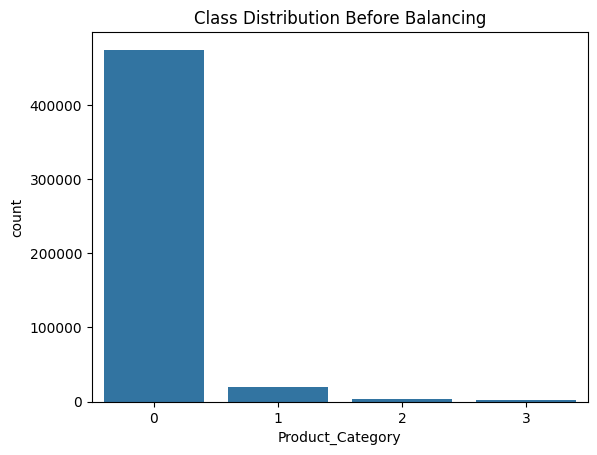

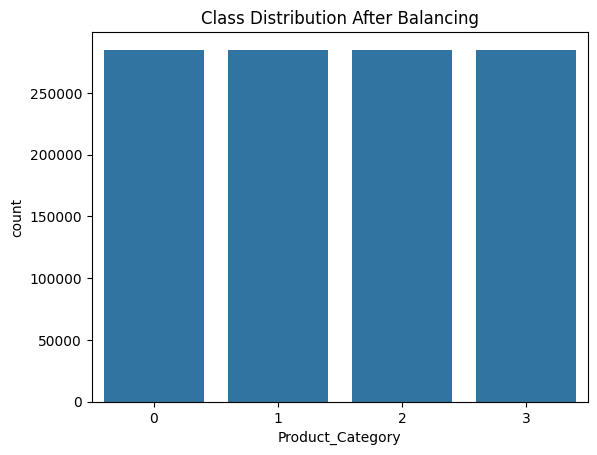

Training BiLSTM...


Epoch 1, Loss: 0.1326


Epoch 2, Loss: 0.1242


Epoch 3, Loss: 0.1223
Training CNN-LSTM...


Epoch 1, Loss: 0.4427


Epoch 2, Loss: 0.2659


Epoch 3, Loss: 0.1386
Training Hybrid CNN-BiLSTM...


Epoch 1, Loss: 0.3316


Epoch 2, Loss: 0.2470


Epoch 3, Loss: 0.1489
Classification Report for BiLSTM:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    190027
           1       1.00      1.00      1.00      7926
           2       0.81      0.86      0.84      1471
           3       0.50      0.95      0.65       885

    accuracy                           0.99    200309
   macro avg       0.83      0.95      0.87    200309
weighted avg       1.00      0.99      0.99    200309

Classification Report for CNN-LSTM:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    190027
           1       0.99      1.00      1.00      7926
           2       0.48      0.86      0.62      1471
           3       0.99      0.95      0.97       885

    accuracy                           0.99    200309
   macro avg       0.87      0.95      0.89    200309
weighted avg       0.99      0.99      0.99    200309

Classification Report for Hybrid CNN-B

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
df = pd.read_csv("https://files.consumerfinance.gov/ccdb/complaints.csv.zip", compression='zip', low_memory=False, nrows=550000)
df = df[['Product', 'Issue', 'Sub-issue']].dropna()

# Classify product category
def classify_product(text):
    text = text.lower()
    if any(word in text for word in ["credit", "credit reporting", "repair", "others"]):
        return 0
    if any(word in text for word in ["debt", "debt collection"]):
        return 1
    if any(word in text for word in ["loan", "consumer loan"]):
        return 2
    if "mortgage" in text:
        return 3
    return -1

df['Product_Category'] = df['Product'].apply(classify_product)
df = df[df['Product_Category'] != -1]
df['text'] = df['Issue'] + ' ' + df['Sub-issue']

# Visualize class distribution before balancing
sns.countplot(x=df['Product_Category'])
plt.title("Class Distribution Before Balancing")
plt.show()

# Train-test split
X_train_text, X_test_text, y_train, y_test = train_test_split(df['text'], df['Product_Category'], test_size=0.4, random_state=42, stratify=df['Product_Category'])

# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train_text).toarray()
X_test = vectorizer.transform(X_test_text).toarray()

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Visualize class distribution after balancing
sns.countplot(x=y_train)
plt.title("Class Distribution After Balancing")
plt.show()

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long, device=device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define BiLSTM model with Dropout for regularization
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.3):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        x = self.dropout(lstm_out[:, -1, :])
        return self.fc(x)

# Define CNN-LSTM model with Dropout for regularization
class CNN_LSTM(nn.Module):
    def __init__(self, input_dim, num_filters, kernel_size, hidden_dim, output_dim, dropout_prob=0.3):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size)
        self.lstm = nn.LSTM(num_filters, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = torch.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        x = self.dropout(lstm_out[:, -1, :])
        return self.fc(x)

# Define Hybrid CNN-BiLSTM Model
class HybridCNNBiLSTM(nn.Module):
    def __init__(self, input_dim, num_filters, kernel_size, hidden_dim, output_dim, dropout_prob=0.3):
        super(HybridCNNBiLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size)
        self.lstm = nn.LSTM(num_filters, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = torch.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        x = self.dropout(lstm_out[:, -1, :])
        return self.fc(x)

# Initialize models
input_dim = X_train_tensor.shape[1]
hidden_dim = 128
output_dim = len(np.unique(y_train))
num_filters = 64
kernel_size = 3
dropout_prob = 0.3

bilstm_model = BiLSTM(input_dim, hidden_dim, output_dim, dropout_prob).to(device)
cnn_lstm_model = CNN_LSTM(input_dim, num_filters, kernel_size, hidden_dim, output_dim, dropout_prob).to(device)
hybrid_cnn_bilstm_model = HybridCNNBiLSTM(input_dim, num_filters, kernel_size, hidden_dim, output_dim, dropout_prob).to(device)

# Training function with learning rate scheduler
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for X_batch, y_batch in progress_bar:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
        scheduler.step()  # Update the learning rate
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

# Optimizer, scheduler, and training
optimizer_bilstm = optim.Adam(bilstm_model.parameters(), lr=0.001)
scheduler_bilstm = optim.lr_scheduler.StepLR(optimizer_bilstm, step_size=1, gamma=0.7)  # Reduce LR every epoch

optimizer_cnn_lstm = optim.Adam(cnn_lstm_model.parameters(), lr=0.001)
scheduler_cnn_lstm = optim.lr_scheduler.StepLR(optimizer_cnn_lstm, step_size=1, gamma=0.7)

optimizer_hybrid = optim.Adam(hybrid_cnn_bilstm_model.parameters(), lr=0.001)
scheduler_hybrid = optim.lr_scheduler.StepLR(optimizer_hybrid, step_size=1, gamma=0.7)

print("Training BiLSTM...")
train_model(bilstm_model, train_loader, test_loader, nn.CrossEntropyLoss(weight=class_weights), optimizer_bilstm, scheduler_bilstm)
print("Training CNN-LSTM...")
train_model(cnn_lstm_model, train_loader, test_loader, nn.CrossEntropyLoss(weight=class_weights), optimizer_cnn_lstm, scheduler_cnn_lstm)
print("Training Hybrid CNN-BiLSTM...")
train_model(hybrid_cnn_bilstm_model, train_loader, test_loader, nn.CrossEntropyLoss(weight=class_weights), optimizer_hybrid, scheduler_hybrid)

# Evaluate models
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

y_true_bilstm, y_pred_bilstm = evaluate_model(bilstm_model, test_loader)
y_true_cnn_lstm, y_pred_cnn_lstm = evaluate_model(cnn_lstm_model, test_loader)
y_true_hybrid, y_pred_hybrid = evaluate_model(hybrid_cnn_bilstm_model, test_loader)

print("Classification Report for BiLSTM:")
print(classification_report(y_true_bilstm, y_pred_bilstm))
print("Classification Report for CNN-LSTM:")
print(classification_report(y_true_cnn_lstm, y_pred_cnn_lstm))
print("Classification Report for Hybrid CNN-BiLSTM:")
print(classification_report(y_true_hybrid, y_pred_hybrid))


In [2]:
def predict_sample_text(model, sample_texts):
    # Set the model to evaluation mode
    model.eval()

    # Vectorize the sample texts using the fitted TF-IDF vectorizer
    sample_vectors = vectorizer.transform(sample_texts).toarray()

    # Convert to a PyTorch tensor and move it to the appropriate device (GPU/CPU)
    sample_tensor = torch.tensor(sample_vectors, dtype=torch.float32, device=device)

    # Perform inference without computing gradients
    with torch.no_grad():
        # Get model outputs
        outputs = model(sample_tensor)

        # Get the predicted class (the class with the maximum score)
        _, predictions = torch.max(outputs, 1)

    # Define the label mapping for the predicted class indices
    label_map = {0: "Credit", 1: "Debt", 2: "Loan", 3: "Mortgage"}

    # Return the predicted labels
    return [label_map[pred.item()] for pred in predictions]

# Example sample texts to test the function
sample_texts = [
    "I have an issue with my credit report being incorrect.",
    "Debt collection agency is harassing me.",
    "I need help with my student loan repayment.",
    "My mortgage payment was miscalculated."
]

# Use the updated function with BiLSTM, CNN-LSTM, and Hybrid CNN-BiLSTM models
print("BiLSTM Predictions:", predict_sample_text(bilstm_model, sample_texts))
print("CNN + LSTM Predictions:", predict_sample_text(cnn_lstm_model, sample_texts))
print("Hybrid CNN-BiLSTM Predictions:", predict_sample_text(hybrid_cnn_bilstm_model, sample_texts))


BiLSTM Predictions: ['Credit', 'Debt', 'Loan', 'Mortgage']
CNN + LSTM Predictions: ['Loan', 'Loan', 'Loan', 'Debt']
Hybrid CNN-BiLSTM Predictions: ['Credit', 'Loan', 'Loan', 'Debt']
